This is an exploration of X-ray image data obtained from https://github.com/paras42/Hello_World_Deep_Learning

We will do the following things:

- Preprocess the dataset to the correct format for Keras sequential models, including applying data augmentation 
- Apply PCA and visualise explained variance
- Use reduced dimensional data to train a sequential model and evaluate performance
- Visualise the data using TSNE and Hierarchical Clustering
- Apply transfer learning of Google's Inception V3 to the X-ray dataset and evaluate performance
- Produce sample augmented images and feature maps
- Build a COVID-19 binary classification model by retraining X-ray classification model

In [1]:
from keras import backend

Using TensorFlow backend.


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Here I have imported the necessary modules to generate the image data and apply real-time augmentation. 

Code is referenced in Methodology: Keras Sequential Model 4.1, Preprocessing 4.2 and Dimensionality Reduction 4.3

In [3]:
#Import necessary modules
import keras as K
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.regularizers import l1, l2
from keras import metrics
from keras.utils import plot_model
import pydot as pyd
from keras.applications.inception_v3 import InceptionV3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from numpy import concatenate
from PIL import Image 

# Dimensions of our images.
img_width, img_height = 299, 299

# Location of training data
train_data_dir = r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TRAIN"

# Location of validation data
validation_data_dir = r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\VAL"


# Number of samples used for determining the samples per epoch
nb_train_samples = 65
nb_validation_samples = 10
epochs = 20
batch_size = 5  

# Using ImageDataGenerator() to rescale images and apply real time augmentation
# Training data with augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        shear_range=0.2,      
        zoom_range=0.2,    
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True) 

# Validation Data without augmentation 
val_datagen = ImageDataGenerator(
        rescale=1./255)       # normalize pixel values to [0,1]

# Producing batches of image data to be accepted by Keras Seqential Model using 'model.fit_generator()'
# Training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


## PCA data preprocessing: see Dimensionality Reduction (Section 4.3)

Found 65 images belonging to 2 classes.


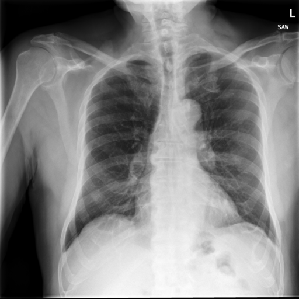

None
[1.]
(65, 299, 299, 3)
(10, 299, 299, 3)
(65, 268203)
(10, 268203)
(75, 268203)
(75,)


In [4]:
# Training data without augmentation (for use in PCA)
train_datagen2 = ImageDataGenerator(
        rescale=1./255)      # normalize pixel values to [0,1]

train_generator2 = train_datagen2.flow_from_directory(
    train_data_dir,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

# Convert non-augmented training and validation data into numpy arrays for use in PCA
# Data is converted from train_generator using '.next()' method to iterate through batches of 5

# Produced in batches of 5 so range(13) produces 5x13 = 65 training images 
train_images = np.concatenate([train_generator2.next()[0] for i in range(13)])
train_labels2 = np.concatenate([train_generator2.next()[1] for i in range(13)])
train_labels = np.reshape(train_labels2,(65,1))

# range(2) produces 5x2 = 10 validation images
val_images = np.concatenate([validation_generator.next()[0] for i in range(2)])
val_labels2 = np.concatenate([validation_generator.next()[1] for i in range(2)])
val_labels = np.reshape(val_labels2,(10,1))

# Check images match up to label
print(display(array_to_img(train_images[24])))
print(train_labels[24])

# Check shape of data
print(train_images.shape)
# (65, 299, 299, 3)
print(val_images.shape)
# (10, 299, 299, 3)

# Flatten the images in 2D tensor (matrix) using (65,299x299x3) = (65,268203)
train_images = np.reshape(train_images,(65,268203))
val_images = np.reshape(val_images,(10,268203))

# Check shape is correct
print(train_images.shape)
# (65, 268203)
print(val_images.shape)
# (10, 268203)

# Concatenate (combine) images and labels from both training and validation data 
# This is because with less that 75 images we need 23 PCs for 90% variance 
# and PCA cannot produce 23 PCs on 10 validation images so we produce 23 PCs on 75 combined images
images = np.concatenate((train_images,val_images))
labels = np.concatenate((train_labels2,val_labels2))

print(images.shape)
# (75, 268203)
print(labels.shape)
# (75,)

## PCA exploration: see Dimensionality Reduction (Section 4.3)

PCA done! Time elapsed: 3.40858793258667 seconds
Variance explained per principal component: [0.3579294  0.09307046 0.08755947 0.06722911 0.04470541 0.03544103
 0.03251021 0.02894037 0.02251316 0.01800802 0.01567763 0.01442155
 0.01145872 0.01030645 0.00957119 0.00832102 0.00770604 0.00750082
 0.00680114 0.00658207 0.00599621 0.00534518 0.00500813]
(75, 23)


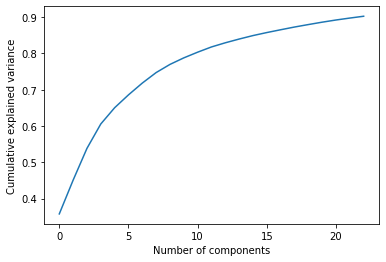

In [5]:
# Import PCA module from scikit learn and other used modules
from sklearn.decomposition import PCA
import os
import time

# Conducting PCA on numpy arrays of X-ray data
# Used 'n_components=0.9' to capture 90% of data variance which produces 23 Principal Components (eigenvectors)
# from combined dataset of 75 images
time_start = time.time()
pca = PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,  svd_solver='auto', tol=0.0, whiten=True)
pca.fit(images)
pca_images = pca.transform(images)

# Produce graph of cumulative explained variance from 23 PCs
# and print eigenvalues as 'Variance explained per principal component'
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

# Check tensor shape
print(pca_images.shape)
# (75,23)

## Constructing Keras sequential model from pca_images: see Dimensionality Reduction (Section 4.3)

In [6]:
modelPCA = Sequential() 
# hidden layer 1
modelPCA.add(Dense(1024, activation='relu', input_shape=(23,)))
modelPCA.add(Dropout(0.25))
modelPCA.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# hidden layer 2
modelPCA.add(Dense(1024, activation='relu'))
modelPCA.add(Dropout(0.25))
modelPCA.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# hidden layer 3
modelPCA.add(Dense(512, activation='relu'))
# hidden layer 4
modelPCA.add(Dense(256, activation='relu'))
# output layer
modelPCA.add(Dense(1, activation='sigmoid')) #used ‘sigmoid’ for the output layer as this is a binary classification.

# compile using Adam optimisation algorithm
modelPCA.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='binary_crossentropy', metrics=['accuracy', metrics.mae])

# train PCA model (no validation used here as train and validation sets are combined)
historyPCA = modelPCA.fit(pca_images, labels,batch_size=batch_size,epochs=epochs,verbose=1,
                    validation_data=None)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





75/75 [==============================] - 4s 52ms/step - loss: 0.9171 - acc: 0.4533 - mean_absolute_error: 0.5172
Epoch 2/20
75/75 [==============================] - 0s 6ms/step - loss: 0.6700 - acc: 0.4933 - mean_absolute_error: 0.4595
Epoch 3/20
75/75 [==============================] - 0s 6ms/step - loss: 0.6002 - acc: 0.6933 - mean_absolute_error: 0.4230
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 0.5450 - acc: 0.7333 - mean_absolute_error: 0.3924
Epoch 5/20
75/75 [==============================] - 0s 6ms/step - loss: 0.5211 - acc: 0.7733 - mean_absolute_error: 0.3787
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 0.5055 - acc: 0.7600 - mean_absolute_error: 0.3502
Epoch 7/20
75/75 [====================

dict_keys(['loss', 'acc', 'mean_absolute_error'])


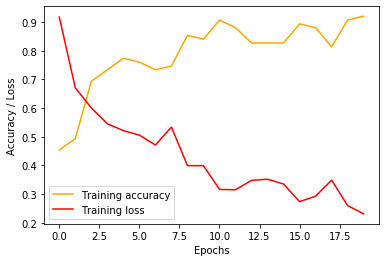

In [7]:
# Produce PCA performance graph
print(historyPCA.history.keys())
plt.figure()
plt.plot(historyPCA.history['acc'], 'orange', label='Training accuracy')
plt.plot(historyPCA.history['loss'], 'red', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

In [8]:
# Produce accuracy measures
loss = modelPCA.evaluate(pca_images, labels)
print(modelPCA.metrics_names)
print(loss)
print("Accuracy = ", loss[1])

75/75 [==============================] - 1s 7ms/step
['loss', 'acc', 'mean_absolute_error']
[0.09018172105153402, 0.9866666706403097, 0.07792708834012349]
Accuracy =  0.9866666706403097


## Produce TSNE visualisation of data: see Dimensionality Reduction (Section 4.3)

t-SNE done! Time elapsed: 2.4299826622009277 seconds


Text(0, 0.5, 'Dimension 2')

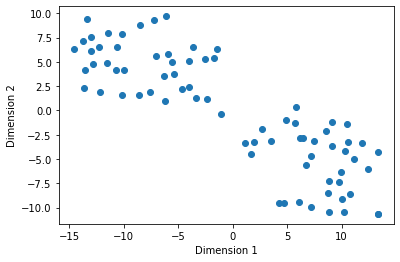

In [9]:
# Import TSNE from sckit learn
from sklearn.manifold import TSNE
time_start = time.time()

tsne_images = TSNE(perplexity=15,learning_rate=1).fit_transform(images)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_images.shape
x = [tsne[0] for tsne in tsne_images]
y = [tsne[1] for tsne in tsne_images]
plt.scatter(x,y)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# Graph produced shows clear seperation of data into clusters
# different 'perplexity' values produce different plots (some with less clear speration)

## Producing dendrogram from X-ray data using hierarchical clustering: see Hierarchical Clustering (Section 3.6.1)

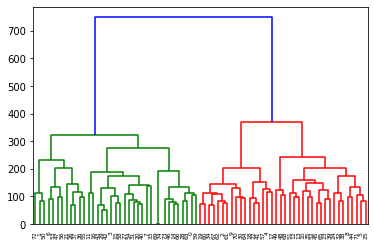

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(images, method='ward'))
#Looking at the dendrogram, the highest vertical distance that doesn’t intersect with any clusters is the top blue one.
#Given that 2 vertical lines cross the threshold, the optimal number of clusters is 2.

# Full X-Ray binary classification model using Google's Inception V3 as source model: see Keras Sequential Model (Section 4.1)

In [11]:
source_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [12]:
# Check input and output shape of source model
print(source_model.input_shape[0:])
print(source_model.output_shape[0:])

(None, 299, 299, 3)
(None, 8, 8, 2048)


In [38]:
# Define sequential model
model_top = Sequential()
# hidden convolutional layer 1
model_top.add(Conv2D(16, (3, 3), input_shape=(8,8,2048), activation='relu', padding='valid'))
# hidden convolutional layer 2
model_top.add(Conv2D(16, (5, 5), activation='relu', padding='valid'))
model_top.add(GlobalMaxPooling2D(input_shape=(299, 299, 3), data_format=None))  
# hidden layer 3
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.25))
model_top.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# hidden layer 4
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.25))
model_top.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# output layer
model_top.add(Dense(1, activation='sigmoid')) #used ‘sigmoid’ for the output layer as this is a binary classification.

# Produce summary of model to be trained on X-ray data
model_top.summary()
#Total params: 373,793
#Trainable params: 372,769
#Non-trainable params: 1,024

# Combine with Inception V3 (source) model
model = Model(inputs=source_model.input, outputs=model_top(source_model.output))

# Produce summary of full model
#model.summary()
#Total params: 22,176,577
#Trainable params: 22,141,121
#Non-trainable params: 35,456

# Compile using Adam optimisation algorithm 
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy', metrics.mae])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_195 (Conv2D)          (None, 6, 6, 16)          294928    
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 2, 2, 16)          6416      
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               4352      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_197 (Bat (None, 256)               1024      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
__________

In [39]:
# Train model on train and validation generators
history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
13/13 [==============================] - 127s 10s/step - loss: 0.6990 - acc: 0.6308 - mean_absolute_error: 0.4256 - val_loss: 0.6694 - val_acc: 0.5000 - val_mean_absolute_error: 0.4601
Epoch 2/20
13/13 [==============================] - 50s 4s/step - loss: 0.6498 - acc: 0.6615 - mean_absolute_error: 0.3918 - val_loss: 0.7061 - val_acc: 0.4000 - val_mean_absolute_error: 0.4625
Epoch 3/20
13/13 [==============================] - 52s 4s/step - loss: 0.4338 - acc: 0.8154 - mean_absolute_error: 0.2989 - val_loss: 0.6552 - val_acc: 0.6000 - val_mean_absolute_error: 0.3758
Epoch 4/20
13/13 [==============================] - 53s 4s/step - loss: 0.4745 - acc: 0.7846 - mean_absolute_error: 0.2947 - val_loss: 0.2621 - val_acc: 1.0000 - val_mean_absolute_error: 0.2162
Epoch 5/20
13/13 [==============================] - 53s 4s/step - loss: 0.3355 - acc: 0.8462 - mean_absolute_error: 0.2276 - val_loss: 0.1784 - val_acc: 0.9000 - val_mean_absolute_error: 0.1332
Epoch 6/20
13/13 [==========

dict_keys(['val_loss', 'val_acc', 'val_mean_absolute_error', 'loss', 'acc', 'mean_absolute_error'])


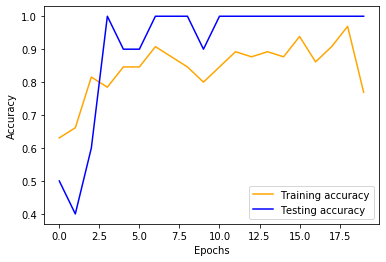

In [40]:
# Produce accuracy curve
print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

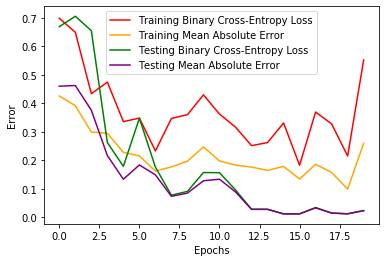

In [41]:
# Produce loss curve
plt.figure()
plt.plot(history.history['loss'], 'red', label='Training Binary Cross-Entropy Loss')
plt.plot(history.history['mean_absolute_error'], 'orange', label='Training Mean Absolute Error')
plt.plot(history.history['val_loss'], 'green', label='Testing Binary Cross-Entropy Loss')
plt.plot(history.history['val_mean_absolute_error'], 'purple', label='Testing Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [63]:
# Mean average values of BCE for training and testing respectively
print(sum(history.history['loss'])/20)
#0.3739572982088878
print(sum(history.history['val_loss'])/20)
#0.1865787618793547

0.3739572982088878
0.1865787618793547


## Testing model on individual images from test set and externally obtained images: see Model Evaluation (Section 5)

Images from test set (unseen by model)

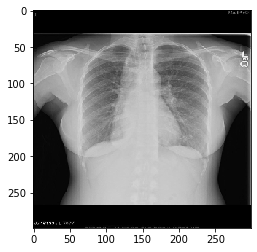

Predicted: [[0.1316511]] Chest X-ray


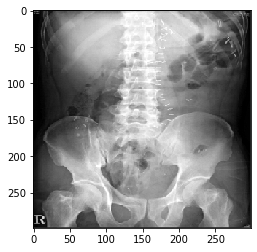

Predicted: [[0.998223]] Abd X-ray


In [42]:
import numpy as np
from keras.preprocessing import image

# Image locations
img_path= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TEST\chest2.png"
img_path2= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TEST\abd2.png"

# Load images
img = image.load_img(img_path, target_size=(299,299))
img2 = image.load_img(img_path2, target_size=(299,299))

# Show image which is being classified: Chest X-ray
plt.imshow(img)
plt.show()

# Convert to array
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255     # normalize pixel values to [0,1]
# Use model to classify image
score = model.predict(x)
# Round scores to give qualitative classification of image
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

# Abdominal X-ray
plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')

Externally obtained images from: https://radiopaedia.org/cases/normal-chest-x-ray

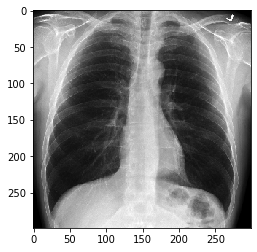

Predicted: [[0.01937448]] Chest X-ray


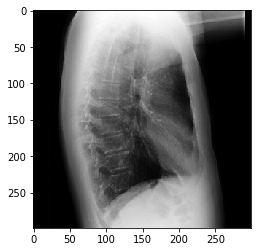

Predicted: [[0.34242734]] Chest X-ray


In [43]:
# Image locations
img_path= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\other\76052f7902246ff862f52f5d3cd9cd_jumbo.jpg"
img_path2= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\other\da9ebbb115dc5a6bc77a65541789eb_jumbo.jpg"

# Load images
img = image.load_img(img_path, target_size=(299, 299))
img2 = image.load_img(img_path2, target_size=(299, 299))

# Show image which is being classified: Chest X-ray
plt.imshow(img)
plt.show()

# Convert to array
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255     # normalize pixel values to [0,1]
# Use model to classify image
score = model.predict(x)
# Round scores to give qualitative classification of image
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

# Side view Chest X-ray
plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')


In [44]:
# Produce accuracy measures
loss = model.evaluate_generator(train_generator, len(train_generator),  workers = 1)
print(model.metrics_names)
print(loss)
print("Accuracy = ", loss[1])

['loss', 'acc', 'mean_absolute_error']
[0.2372180289373948, 0.9076923131942749, 0.15236068345033205]
Accuracy =  0.9076923131942749


In [45]:
# Produce confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

Y_pred = model.predict_generator(train_generator, 13)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_generator.classes, y_pred))

Confusion Matrix
[[33  0]
 [32  0]]


## Sample Augmented images shown in Preprocessing (Section 4.2: Figure 6)

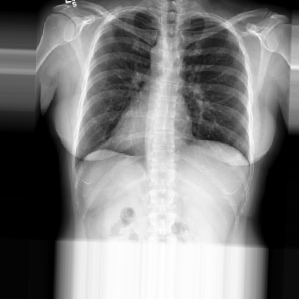

None


In [46]:
# Producing sample augmented images using '.next()' method and displaying transformed image
augmented_images = np.concatenate([train_generator.next()[0] for i in range(13)])
print(display(array_to_img(augmented_images[24])))

## Feature maps shown in Convolutional Neural Network (Section 3.7.4: Figure 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
[[[ 32.  32.  32.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  7.   7.   7.]
  [  6.   6.   6.]
  [ 33.  33.  33.]]

 [[ 40.  40.  40.]
  [ 61.  61.  61.]
  [ 31.  31.  31.]
  ...
  [  4.   4.   4.]
  [  3.   3.   3.]
  [ 33.  33.  33.]]

 [[ 34.  34.  34.]
  [ 32.  32.  32.]
  [ 20.  20.  20.]
  ...
  [  4.   4.   4.]
  [  3.   3.   3.]
  [ 35.  35.  35.]]

 ...

 [[ 34.  34.  34.]
  [ 10.  10.  10.]
  [  4.   4.   4.]
  ...
  [ 81.  81.  81.]
  [123. 123. 123.]
  [ 44.  44.  44.]]

 [[ 33.  33.  33.]
  [  3.   3.   3.]
  [ 

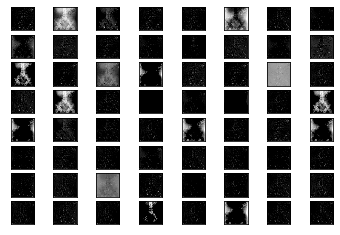

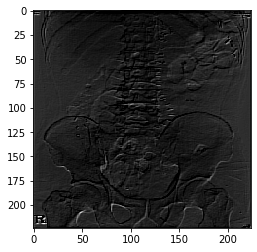

In [47]:
# producing feature maps from first convolutional layer for given image

# Import VGG16 model and produce feature maps
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from matplotlib import pyplot
from numpy import expand_dims
# load the model
modelVG = VGG16()
# redefine model to output right after the first hidden layer
modelVG = Model(inputs=modelVG.inputs, outputs=modelVG.layers[1].output)
modelVG.summary()
# load the image with the required shape [(224,224) for VGG16 model]
img = load_img(r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TEST\abd2.png", target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
print(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = modelVG.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

# show individual feature maps
pyplot.imshow(feature_maps[0, :, :, 15], cmap='gray')

## As a further exploration of binary classification models, this model can be repurposed for the diagnosis of COVID-19 using samples obtained from https://github.com/ieee8023/covid-chestxray-dataset

In [48]:
# Dimensions of our images.
img_width, img_height = 299, 299

# Location of training data
train_data_dirCOVID = r"C:\Users\benke\Documents\Year 3\Deep Learning\COVID-19\dataset\Train"

# Location of testing data
test_data_dirCOVID = r"C:\Users\benke\Documents\Year 3\Deep Learning\COVID-19\dataset\Test"


# Number of samples used for determining the samples per epoch
nb_train_samplesCOVID = 30
nb_test_samplesCOVID = 18
epochs = 20
batch_size = 5  

# Using ImageDataGenerator() to rescale images and apply real time augmentation
# Training data with augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        shear_range=0.2,      
        zoom_range=0.2,    
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True) 

# Validation Data without augmentation 
test_datagen = ImageDataGenerator(
        rescale=1./255)       # normalize pixel values to [0,1]

# Producing batches of image data to be accepted by Keras Seqential Model using 'model.fit_generator()'
# Training generator
train_generatorCOVID = train_datagen.flow_from_directory(
    train_data_dirCOVID,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

# Validation generator
test_generatorCOVID = test_datagen.flow_from_directory(
    test_data_dirCOVID,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

Found 30 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [49]:
source_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [50]:
# Define sequential model
model_top = Sequential()
# hidden convolutional layer 1
model_top.add(Conv2D(16, (3, 3), input_shape=(8,8,2048), activation='relu', padding='valid'))
# hidden convolutional layer 2
model_top.add(Conv2D(16, (5, 5), activation='relu', padding='valid'))
model_top.add(GlobalMaxPooling2D(input_shape=source_model.output_shape[1:], data_format=None))
#model_top.add(GlobalMaxPooling2D(input_shape=(299, 299, 3), data_format=None))  
# hidden layer 3
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.25))
model_top.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# hidden layer 4
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.25))
model_top.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# output layer
model_top.add(Dense(1, activation='sigmoid')) #used ‘sigmoid’ for the output layer as this is a binary classification.

# Produce summary of model to be trained on X-ray data
model_top.summary()
#Total params: 373,793
#Trainable params: 372,769
#Non-trainable params: 1,024

# Combine with Inception V3 (source) model
modelCOVID = Model(inputs=source_model.input, outputs=model_top(source_model.output))

# Produce summary of full model
#modelCOVID.summary()
#Total params: 22,176,577
#Trainable params: 22,141,121
#Non-trainable params: 35,456 

# Compile using Adam optimisation algorithm 
modelCOVID.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy', metrics.mae])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_291 (Conv2D)          (None, 6, 6, 16)          294928    
_________________________________________________________________
conv2d_292 (Conv2D)          (None, 2, 2, 16)          6416      
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               4352      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_293 (Bat (None, 256)               1024      
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
__________

In [51]:
# Train model on train and validation generators
historyCOVID = modelCOVID.fit_generator(
            train_generatorCOVID,
            steps_per_epoch=nb_train_samplesCOVID // batch_size,
            epochs=20,
            validation_data=test_generatorCOVID,
            validation_steps=nb_test_samplesCOVID // batch_size)

Epoch 1/20
6/6 [==============================] - 113s 19s/step - loss: 0.8178 - acc: 0.6000 - mean_absolute_error: 0.4560 - val_loss: 0.5829 - val_acc: 0.7333 - val_mean_absolute_error: 0.3828
Epoch 2/20
6/6 [==============================] - 27s 5s/step - loss: 0.7500 - acc: 0.5333 - mean_absolute_error: 0.4751 - val_loss: 0.4789 - val_acc: 0.8462 - val_mean_absolute_error: 0.2862
Epoch 3/20
6/6 [==============================] - 26s 4s/step - loss: 0.6348 - acc: 0.7000 - mean_absolute_error: 0.3879 - val_loss: 1.0159 - val_acc: 0.4615 - val_mean_absolute_error: 0.5346
Epoch 4/20
6/6 [==============================] - 26s 4s/step - loss: 0.7218 - acc: 0.6333 - mean_absolute_error: 0.4472 - val_loss: 0.6738 - val_acc: 0.6923 - val_mean_absolute_error: 0.3910
Epoch 5/20
6/6 [==============================] - 27s 5s/step - loss: 0.4970 - acc: 0.7667 - mean_absolute_error: 0.3227 - val_loss: 0.8841 - val_acc: 0.4000 - val_mean_absolute_error: 0.5136
Epoch 6/20
6/6 [======================

dict_keys(['val_loss', 'val_acc', 'val_mean_absolute_error', 'loss', 'acc', 'mean_absolute_error'])


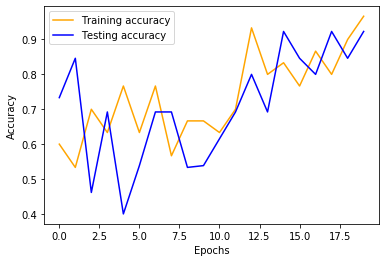

In [52]:
# Produce accuracy curve
print(historyCOVID.history.keys())

plt.figure()
plt.plot(historyCOVID.history['acc'], 'orange', label='Training accuracy')
plt.plot(historyCOVID.history['val_acc'], 'blue', label='Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

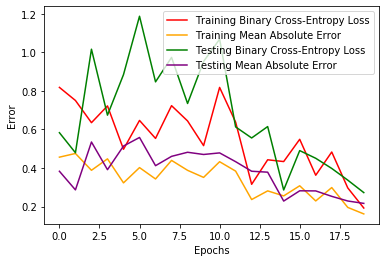

In [53]:
# Produce loss curve
plt.figure()
plt.plot(historyCOVID.history['loss'], 'red', label='Training Binary Cross-Entropy Loss')
plt.plot(historyCOVID.history['mean_absolute_error'], 'orange', label='Training Mean Absolute Error')
plt.plot(historyCOVID.history['val_loss'], 'green', label='Testing Binary Cross-Entropy Loss')
plt.plot(historyCOVID.history['val_mean_absolute_error'], 'purple', label='Testing Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [67]:
# Mean average values of BCE for training and testing respectively
print(sum(historyCOVID.history['loss'])/20)
#0.5515911644945543
print(sum(historyCOVID.history['val_loss'])/20)
#0.6705862277593369

0.5515911644945543
0.6705862277593369


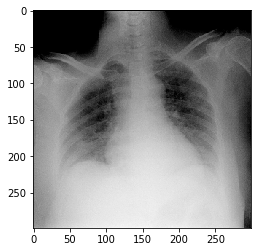

Predicted: [[0.24212164]] COVID-19 Confirmed


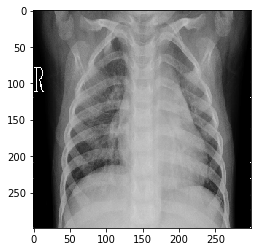

Predicted: [[0.6013103]] Healthy


In [54]:
import numpy as np
from keras.preprocessing import image

# Image locations
img_path= r"C:\Users\benke\Documents\Year 3\Deep Learning\COVID-19\dataset\X\COVID-19.jpg"
img_path2= r"C:\Users\benke\Documents\Year 3\Deep Learning\COVID-19\dataset\X\Normal.jpeg"

# Load images
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))

# COVID-19 X-ray Image
plt.imshow(img)
plt.show()

# Convert to array
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255     # normalize pixel values to [0,1]
# Use model to classify image
score = modelCOVID.predict(x)
# Round scores to give qualitative classification of image
print('Predicted:', score, 'COVID-19 Confirmed' if score < 0.5 else 'Healthy')

# Healthy X-ray Image
plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = modelCOVID.predict(x)
print('Predicted:', score2, 'COVID-19 Confirmed' if score2 < 0.5 else 'Healthy')

In [55]:
# Produce accuracy measures
loss = modelCOVID.evaluate_generator(train_generatorCOVID, len(train_generatorCOVID),  workers = 1)
print(modelCOVID.metrics_names)
print(loss)
print("Accuracy = ", loss[1])

['loss', 'acc', 'mean_absolute_error']
[0.17049927016099295, 0.9666666686534882, 0.1405815730492274]
Accuracy =  0.9666666686534882
